In [57]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import DL_project_utils as utils
import dlc_practical_prologue as prologue

%load_ext autoreload
%autoreload 1
%aimport DL_project_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn2 = nn.BatchNorm2d(nb_channels)

        self.skip_connections = skip_connections
        self.batch_normalization = batch_normalization

    def forward(self, x):
        y = self.conv1(x)
        if self.batch_normalization: y = self.bn1(y)
        y = F.relu(y)
        y = self.conv2(y)
        if self.batch_normalization: y = self.bn2(y)
        if self.skip_connections: y = y + x
        y = F.relu(y)
        

        return y

In [186]:
class ResNet(nn.Module):

    def __init__(self, nb_residual_blocks, nb_channels,
                 kernel_size, nb_classes = 10,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv = nn.Conv2d(2, nb_channels,
                              kernel_size = kernel_size,
                              padding = (kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(nb_channels)

        self.resnet_blocks = nn.Sequential(
            *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
              for _ in range(nb_residual_blocks))
        )

        self.fc = nn.Linear(nb_channels, nb_classes)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.resnet_blocks(x)
        x = F.avg_pool2d(x, 14).view(x.size(0), -1)
        x = self.fc(x)
        return x

In [34]:
train_data, test_data = utils.read_input(normalize=True, pairs=1000, verbose=True)

train_input torch.Size([1000, 2, 14, 14]) train_target torch.Size([1000]) train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14]) test_target torch.Size([1000]) test_classes torch.Size([1000, 2])
normalize train and test datasets with train mean & std


In [261]:
epochs, lr, loss, optimizer, batch_size = 20, 0.005, 'cross_entropy', 'Adam', 100
model = ResNet(nb_residual_blocks = 10, nb_channels = 10, kernel_size = 5, nb_classes = 2)
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, learning_rate=lr,
                                                             epochs=epochs, batch_size=batch_size, 
                                                             optimizer=optimizer, loss=loss,weight_decay=0.01)


Epoch: 1/20, Train Loss: 0.718959, Train Accuracy 52.625000% Val Loss: 0.685583, Val Accuracy: 54.500000%             109/200

Epoch: 2/20, Train Loss: 0.657106, Train Accuracy 58.875000% Val Loss: 0.622548, Val Accuracy: 69.000000%             138/200

Epoch: 3/20, Train Loss: 0.582058, Train Accuracy 69.625000% Val Loss: 0.583327, Val Accuracy: 71.000000%             142/200

Epoch: 4/20, Train Loss: 0.508731, Train Accuracy 74.125000% Val Loss: 0.508063, Val Accuracy: 73.000000%             146/200

Epoch: 5/20, Train Loss: 0.488715, Train Accuracy 75.625000% Val Loss: 0.622834, Val Accuracy: 65.000000%             130/200

Epoch: 6/20, Train Loss: 0.423869, Train Accuracy 81.375000% Val Loss: 0.442831, Val Accuracy: 78.500000%             157/200

Epoch: 7/20, Train Loss: 0.367124, Train Accuracy 85.000000% Val Loss: 0.416888, Val Accuracy: 82.000000%             164/200

Epoch: 8/20, Train Loss: 0.340311, Train Accuracy 85.000000% Val Loss: 0.766978, Val Accuracy: 61.000000%     

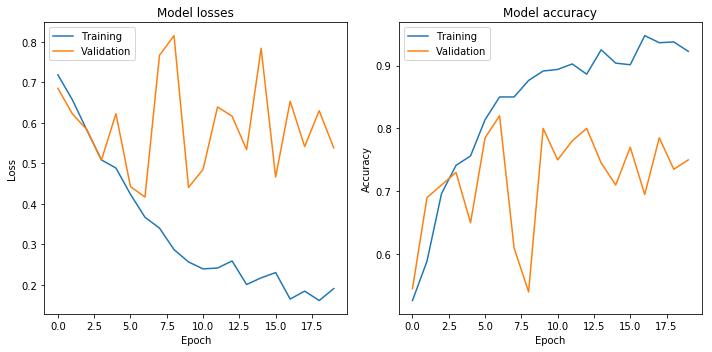

In [262]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [245]:
100 * utils.evaluate_model(model, test_data, cuda=False, batch_size=100)

82.5